### Install and import necessary packages

In [1]:
!pip install transformers seqeval[gpu]
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.1 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 101 kB 11.8 MB/s 
     |████████████████████████████████| 596 kB 69.7 MB/s 
     |████████████████████████████████| 6.6 MB 44.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=519087d0e314ac0d8e1e6d5472a1352e63daad1363435f30721325a2bab1a552
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 4.3 MB/s 
     |█████████████████

In [2]:
import torch
import datasets
from collections import Counter
from datasets import load_dataset
from datasets import Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

In [3]:
torch.cuda.is_available()
device = torch.device("cuda")

## Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!ls '/content/drive/MyDrive/eth_CIL_exercise/data'
df_train = pd.read_csv('/content/drive/MyDrive/eth_CIL_exercise/data/clean_train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/eth_CIL_exercise/data/clean_val.csv')
df_test = pd.read_csv('/content/drive/MyDrive/eth_CIL_exercise/data/clean_test.csv')
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)


Mounted at /content/drive
clean_test.csv	clean_train.csv  clean_val.csv	logreg_input
(2000000, 2)
(500000, 2)
(10000, 2)


In [5]:
# Create dictionaries to transform from labels to id and vice-versa.
id2label = {0 : 'negative',
            1 : 'positive'}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(id2label)
print(id2label)

{0: 'negative', 1: 'positive'}


In [6]:
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)
train_ds[8] # Example of instance of the dataset

{'sentiment': 1,
 'tweet': 'recruiting senior sales manager for the spanish market ( based in dublin ) <url> please rt'}

## Data EDA

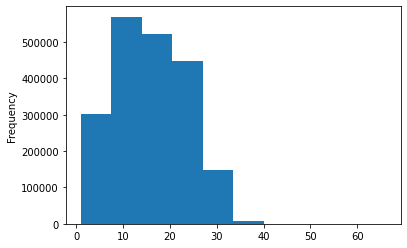

In [7]:
# Get length of each datapoint from the train dataset #remember to do it for all trainset
length = []
for line in train_ds:
  length.append(len(line['tweet'].split()))
#histogram
df = pd.Series(length)
ax = df.plot.hist()


# Tokenizing data - Model name

**model_name**
- [] model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
- [] model_name = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
- [] model_name = 'finiteautomata/bertweet-base-sentiment-analysis'
- [x] model_name = 'siebert/sentiment-roberta-large-english'


In [8]:
# Load BERT/ROBERTA/XLNet tokenizer.
model_name = 'finiteautomata/bertweet-base-sentiment-analysis'

In [9]:
#tokenizer = XLNetTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [10]:
#example: tokenizing one row
tokenizer(train_ds[7]['tweet'])

{'input_ids': [0, 1542, 34574, 7890, 773, 6707, 75, 6665, 6707, 119, 26, 2664, 1683, 583, 47811, 592, 4074, 7812, 6707, 57, 16326, 36495, 33, 6707, 17, 28, 10584, 1556, 836, 241, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [11]:

def encode_dataset(dataset: datasets.arrow_dataset.Dataset) -> list:
  '''
  Transforming each instance of the dataset with the Tokenizer
  '''
  encoded_dataset = []
  for item in dataset:
    # Tokenize the sentence.
    sentence_encoded = tokenizer(item['tweet'],
                                return_tensors="pt", 
                                padding='max_length', 
                                truncation=True, 
                                max_length=40) 
    
    sentence_encoded['labels'] = torch.LongTensor(np.array([item['sentiment']]))
    encoded_dataset.append(sentence_encoded)

  # Reduce dimensionality of tensors.
  for item in encoded_dataset:
    for key in item:
      item[key] = torch.squeeze(item[key])
  return encoded_dataset

In [12]:
# Tokenizing datasets
encoded_dataset_train = encode_dataset(train_ds)
encoded_dataset_val = encode_dataset(val_ds)
encoded_dataset_test = encode_dataset(test_ds)

In [13]:
# Example of dataset
for token, token_label in zip(tokenizer.convert_ids_to_tokens(encoded_dataset_train[50]["input_ids"]), encoded_dataset_train[50]["input_ids"]):
  print('{0:10}  {1}'.format(token, token_label))

<s>         0
<@@         10584
user@@      56843
>           241
i           37
would       86
love        71
to          9
be          31
your        44
ds          1653
friend      352
dan         6754
!           12
what@@      9247
's          20
ya          320
username    7986
?           21
mine        780
:           22
villa@@     42723
ge@@        2231
princess    4984
</s>        2
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1
<pad>       1


# Fine tunning of the model

In [14]:
# Common training arguments
training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    logging_dir='logs',
    no_cuda=False,  
    output_dir = 'drive/MyDrive/eth_CIL_exercise/',
    seed = 82,
    learning_rate = 5e-5
)

# Dictionary to save the results
models_performance ={}

# FINE TUNING PROCESS

# create model
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=num_labels,ignore_mismatched_sizes=True) 
#model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
'''
model.transformer.mask_emb.requires_grad = False
model.transformer.word_embedding.weight.requires_grad = False
for name, param in model.transformer.layer.named_parameters():
  try:
    layer = int(name[:2])
  except ValueError:
    try:
      layer = int(name[:1])
    except ValueError:
      layer = 0
  if layer <= 20:
    param.requires_grad = False'''


# Create trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=encoded_dataset_train,)

# Fine tunning
trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2000000
  Num Epochs = 1
  Instantaneous batch size per device = 256
  Total

Step,Training Loss
500,0.279200
1000,0.247000
1500,0.239200
2000,0.231000
2500,0.228600
3000,0.224500
3500,0.222700
4000,0.219300
4500,0.216300
5000,0.213900


Saving model checkpoint to drive/MyDrive/eth_CIL_exercise/checkpoint-500
Configuration saved in drive/MyDrive/eth_CIL_exercise/checkpoint-500/config.json
Model weights saved in drive/MyDrive/eth_CIL_exercise/checkpoint-500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CIL_exercise/checkpoint-500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CIL_exercise/checkpoint-500/special_tokens_map.json
added tokens file saved in drive/MyDrive/eth_CIL_exercise/checkpoint-500/added_tokens.json
Saving model checkpoint to drive/MyDrive/eth_CIL_exercise/checkpoint-1000
Configuration saved in drive/MyDrive/eth_CIL_exercise/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/eth_CIL_exercise/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CIL_exercise/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CIL_exercise/checkpoint-1000/special_tokens_map.json
added tokens file saved in

TrainOutput(global_step=7813, training_loss=0.22386561888945358, metrics={'train_runtime': 6780.242, 'train_samples_per_second': 294.975, 'train_steps_per_second': 1.152, 'total_flos': 4.11111024e+16, 'train_loss': 0.22386561888945358, 'epoch': 1.0})

In [15]:
#print(model)

# Model evaluation

### Devset

In [16]:
# Get the predicted labels
preds_val = trainer.predict(encoded_dataset_val)
predictions = preds_val.predictions.argmax(-1)

# Create array with predicted labels and expected.
true_values = np.array(preds_val.label_ids).flatten()
predicted_values = np.array(preds_val.predictions.argmax(-1)).flatten()

# Filter the labels. We only produce a label for each word. We filter labels
# of subwords and special tokens, such as PAD
proc_predicted_values = [prediction for prediction, label in zip(predicted_values, true_values) if label != -100]
proc_true_values = [label for prediction, label in zip(predicted_values, true_values) if label != -100]

# Evaluate models
model_performance = {}
model_performance['accuracy'] = accuracy_score(proc_true_values, proc_predicted_values)
model_performance['precision_micro'] = precision_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['precision_macro'] = precision_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['recall_micro'] = recall_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['recall_macro'] = recall_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['f1_micro'] = f1_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['f1_macro'] = f1_score(proc_true_values, proc_predicted_values, average='macro')

model_performance['confusion_matrix'] = confusion_matrix(proc_true_values, proc_predicted_values)
model_performance['confusion_matrix_normalized'] = confusion_matrix(proc_true_values, proc_predicted_values, normalize='true')

***** Running Prediction *****
  Num examples = 500000
  Batch size = 256


In [17]:
print('------------Model performance------------')
print(f'  accuracy: {model_performance["accuracy"]}')
print(f'  f1-micro: {model_performance["f1_micro"]}')
print(f'  f1-macro: {model_performance["f1_macro"]}')
print()

------------Model performance------------
  accuracy: 0.917034
  f1-micro: 0.917034
  f1-macro: 0.9170326093971727



To understand better the performance of the classifier, we display the confusion matrix:

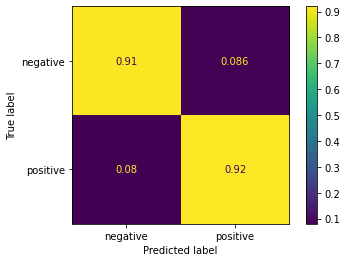

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix_normalized'],display_labels = list(id2label.values()))
disp.plot()

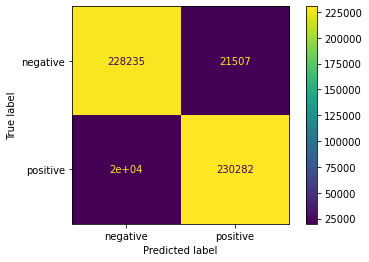

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix'],display_labels = list(id2label.values()))
disp.plot()

exporting probability distribution prediction on devset resulting from trained model

In [21]:
preds_val #we need to retrieve the first elements of this dict

PredictionOutput(predictions=array([[ 2.0977678 , -1.9848568 ],
       [ 1.3582815 , -1.2616016 ],
       [-3.2282043 ,  3.1248305 ],
       ...,
       [-0.31386194,  0.3779387 ],
       [-2.6391256 ,  2.617333  ],
       [ 2.0149424 , -1.9074695 ]], dtype=float32), label_ids=array([0, 0, 1, ..., 0, 1, 0]), metrics={'test_loss': 0.20172663033008575, 'test_runtime': 544.8915, 'test_samples_per_second': 917.614, 'test_steps_per_second': 3.586})

In [22]:
pred_df = pd.DataFrame(preds_val[0]) #predicted_values  
pred_df.to_csv

<bound method NDFrame.to_csv of                0         1
0       2.097768 -1.984857
1       1.358281 -1.261602
2      -3.228204  3.124830
3      -1.367574  1.405012
4      -3.307364  3.213546
...          ...       ...
499995  4.156615 -4.073502
499996  2.723011 -2.582182
499997 -0.313862  0.377939
499998 -2.639126  2.617333
499999  2.014942 -1.907470

[500000 rows x 2 columns]>

In [23]:
pred_df.head(2)

,0,1
0,2.097768,-1.984857
1,1.358281,-1.261602


In [24]:
from google.colab import files
pred_df.to_csv('pred_val_1.csv',index=False,header=False,sep=',')
files.download('pred_val_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Testset - PREDICTION

In [25]:
'''predictions, _ = trainer.predict(test.squeeze().tolist())
pred_bert = pd.DataFrame({'Id': pred_bert.index + 1 ,'Prediction': predictions}) #add columns Id as sample_submission file
pred_bert.loc[pred_bert['Prediction'] < 1, 'Prediction'] = -1 #replace 0 by -1
'''
'''from google.colab import files
pred_bert.to_csv('pred_bert.csv',index=False)
files.download('pred_bert.csv')'''

"from google.colab import files\npred_bert.to_csv('pred_bert.csv',index=False)\nfiles.download('pred_bert.csv')"

In [26]:
# Get the predicted labels
preds = trainer.predict(encoded_dataset_test)
predictions = preds.predictions.argmax(-1)

# Create array with predicted labels and expected.
#TODELETE: true_values = np.array(preds.label_ids).flatten()
predicted_values = np.array(preds.predictions.argmax(-1)).flatten()

***** Running Prediction *****
  Num examples = 10000
  Batch size = 256


In [27]:
pred_dft = pd.DataFrame(preds[0]) #predicted_values  
from google.colab import files
pred_dft.to_csv('pred_test-prob_1.csv',index=False,header=False,sep=',')
files.download('pred_test-prob_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
pred_test = pd.DataFrame({'Prediction': predicted_values})
pred_test = pd.DataFrame({'Id': pred_test.index + 1 ,'Prediction': predicted_values}) #add columns Id as sample_submission file
pred_test.loc[pred_test['Prediction'] < 1, 'Prediction'] = -1 #replace 0 by -1

In [29]:
from google.colab import files
pred_test.to_csv('pred_test_1.csv',index=False)
files.download('pred_test_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>